# Insolation Figure

*This code was originally written by Anni Zhao (Peking) for her PhD thesis when she was at UCL with Chris. It has since been modified to look at the lig127k only and to focus on the high latitudes*

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
from netCDF4 import Dataset
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec
import matplotlib.colors as colors
from matplotlib.lines import Line2D

In [36]:
from datetime import datetime
from scipy.interpolate import CubicSpline

In [3]:
def orbital_month_lengths(e, obliquity, perihelion, T=365.2422):
    """
    Calculates the length (in days) of each "month" for an elliptical orbit,
    where a month is defined as the time required for the ecliptic longitude 
    to advance by 30°.
    
    Parameters:
      e           : orbital eccentricity.
      obliquity   : axial tilt in degrees (not used in this basic model).
      perihelion  : ecliptic longitude of perihelion in degrees (relative to the vernal equinox).
      T           : orbital period in days (default 365.2422).
      
    Assumptions:
      - The vernal equinox is fixed at ecliptic longitude 0°, occurring at noon on March 21.
      - At the vernal equinox the true anomaly is θ₀ = -perihelion (in radians).
      - The 12 month boundaries are defined by ecliptic longitudes 0°, 30°, ..., 330°.
      - The orbital segment that begins at the vernal equinox is assigned to March.
        (Thus, when reporting calendar months the order is:
         January, February, March, …, December, where January corresponds to the segment
         two steps before March.)
    
    Returns:
      A dictionary mapping calendar month names (January, February, …, December)
      to their lengths in days.
    """
    # Convert perihelion to radians
    phi = np.radians(perihelion)
    
    # Define the 12 boundaries in ecliptic longitude (0°, 30°, …, 330°) in radians.
    boundaries = np.radians(np.arange(0, 360, 30))
    
    # For each boundary, the corresponding true anomaly is:
    #   θ = λ - phi
    theta = boundaries - phi  # array of 12 values
    
    # Compute eccentric anomaly E from true anomaly using:
    #   cos(E) = (e + cosθ) / (1 + e*cosθ)
    #   sin(E) = (sqrt(1-e^2)*sinθ) / (1 + e*cosθ)
    cosE = (e + np.cos(theta)) / (1 + e * np.cos(theta))
    sinE = (np.sqrt(1 - e**2) * np.sin(theta)) / (1 + e * np.cos(theta))
    # Use arctan2 to get the correct quadrant, then ensure E is in [0, 2π)
    E = np.mod(np.arctan2(sinE, cosE), 2*np.pi)
    
    # Compute mean anomaly: M = E - e*sin(E)
    M = E - e * np.sin(E)
    
    # Now compute the duration for each 30° segment.
    # For each segment k, the time difference is Δt = T*( (M[k+1]-M[k]) mod 2π )/(2π)
    month_durations = np.empty(12)
    for k in range(12):
        next_k = (k + 1) % 12
        dM = (M[next_k] - M[k]) % (2*np.pi)
        month_durations[k] = T * dM / (2*np.pi)
    
    # The boundaries were defined starting at vernal equinox (λ = 0) which is fixed to March 21.
    # We assign the segment starting at vernal equinox to March.
    # Thus the segments in order (index 0 to 11) correspond to:
    #   0: March, 1: April, …, 9: December, 10: January, 11: February.
    #
    # To report in calendar order starting with January, we need to rotate the array:
    #   January: segment index 10
    #   February: segment index 11
    #   March: segment index 0, and so on.
    reordered = np.empty(12)
    reordered[0] = month_durations[10]  # January
    reordered[1] = month_durations[11]  # February
    reordered[2:12] = month_durations[0:10]  # March to December
    
    month_names = ["January", "February", "March", "April", "May", "June", 
                   "July", "August", "September", "October", "November", "December"]
    
    return dict(zip(month_names, reordered))


10

In [4]:
test_cal = orbital_month_lengths(0.039378, 24.040, 275.41)
print(test_cal)
#extract values of dictionary
values = list(test_cal.values())

#for each value in values, scale by 365/sum(values)
values = np.array(values)
values = values * 365 / sum(values)

#round values to integers
values = np.round(values).astype(int)

values[4] = values[4] - 1
lig_cal = values
print(lig_cal)
print(sum(lig_cal))

{'January': 28.62409265127644, 'February': 29.560716602948773, 'March': 30.76700708549879, 'April': 31.93289901820678, 'May': 32.70985737696166, 'June': 32.83889364077887, 'July': 32.2749251603877, 'August': 31.21064766798752, 'September': 29.979017303585465, 'October': 28.915342397262883, 'November': 28.266200371314298, 'December': 28.16260072379085}
[29 30 31 32 32 33 32 31 30 29 28 28]
365


In [5]:
test_cal = orbital_month_lengths(0.016764, 23.459, 100.33)
print(test_cal)
#extract values of dictionary
values = list(test_cal.values())

#for each value in values, scale by 365/sum(values)
values = np.array(values)
values = values * 365 / sum(values)

#round values to integers
values = np.round(values).astype(int)

values[5] = values[5] + 1
pi_cal = values
print(pi_cal)
print(sum(pi_cal))

{'January': 31.270877459279426, 'February': 30.860582930857987, 'March': 30.34265321861161, 'April': 29.858756929913643, 'May': 29.532710500881638, 'June': 29.44329620567823, 'July': 29.611466833977257, 'August': 29.997581873237056, 'September': 30.506868267437298, 'October': 31.00629504359748, 'November': 31.356523719314378, 'December': 31.454587017214035}
[31 31 30 30 30 30 30 30 30 31 31 31]
365


In [12]:
piline=[11,41,72,102,133,164,194,225,255,286,317,345]
mhline=[12,43,74,103,133,162,191,221,251,283,315,345]
ligline=[12,41,70,97,125,154,183,215,247,281,315,345]

pi_cal = [31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28]
lig_cal  = [32, 29, 29, 27, 28, 29, 29, 32, 32, 34, 34, 30]
greg_cal = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]

pi_cal = [31, 30, 31, 30, 31, 31, 30, 31, 30, 31, 31, 28]
lig_cal  = [32, 29, 29, 27, 28, 29, 29, 32, 32, 34, 34, 30]
greg_cal = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]


In [23]:
def cal_from_line(line, vernal_day=80, months_to_switch=3):
    cal = line.copy()
    for i in range(len(line)): 
        cal[i] = line[i] + vernal_day if line[i] + vernal_day <= 365 else line[i] + vernal_day - 365

    #put the last three months at the beginning
    cal = cal[-months_to_switch:] + cal[:-months_to_switch]
    return cal


In [24]:
pi_cal = cal_from_line(piline, 80)
lig_cal = cal_from_line(ligline, 80)    
print(pi_cal)
print(lig_cal)

[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
[361, 30, 60, 92, 121, 150, 177, 205, 234, 263, 295, 327]


In [4]:

def compress_paleo_to_modern(paleo_data, paleo_calendar, modern_calendar):
    """
    Adjust the paleo daily data so that each paleo month is compressed to have the same 
    number of days as in the modern calendar using linear interpolation.
    
    Parameters:
      paleo_data     : 2D numpy array of shape (total_days, latitudes) for paleo values.
      paleo_calendar : List of 12 integers representing the number of days in each paleo month.
      modern_calendar: List of 12 integers representing the number of days in each modern month.
      
    Returns:
      adjusted_data  : 2D numpy array of shape (total_modern_days, latitudes) where the paleo data 
                       have been regridded to match the modern calendar time steps.
    """
    # Check that the calendars sum up to the number of rows in the data
    total_paleo_days = sum(paleo_calendar)
    total_modern_days = sum(modern_calendar)
    if paleo_data.shape[0] != total_paleo_days:
        raise ValueError(f"Paleo data has {paleo_data.shape[0]} days but the paleo calendar sums to {total_paleo_days}.")
    
    latitudes = paleo_data.shape[1]
    adjusted_data = np.zeros((total_modern_days, latitudes))
    
    paleo_start = 0
    modern_start = 0
    for month in range(12):
        paleo_days = paleo_calendar[month]
        modern_days = modern_calendar[month]
        paleo_end = paleo_start + paleo_days
        modern_end = modern_start + modern_days
        
        # Extract paleo data for the current month; expected shape: (paleo_days, latitudes)
        paleo_segment = paleo_data[paleo_start:paleo_end, :]
        if paleo_segment.shape[0] != paleo_days:
            raise ValueError(f"Expected {paleo_days} days for month {month+1}, but got {paleo_segment.shape[0]}.")
        
        # Create the original time axis (length = paleo_days)
        x_old = np.arange(paleo_days)
        # Create new time axis with modern_days points spanning the same interval
        x_new = np.linspace(0, paleo_days - 1, modern_days)
        
        # Initialize array for the adjusted segment
        adjusted_segment = np.zeros((modern_days, latitudes))
        
        # Interpolate for each latitude
        for lat in range(latitudes):
            # np.interp requires that x_old and paleo_segment[:, lat] have the same length.
            if len(x_old) != len(paleo_segment[:, lat]):
                raise ValueError(f"Length mismatch in month {month+1} for latitude {lat}.")
            adjusted_segment[:, lat] = np.interp(x_new, x_old, paleo_segment[:, lat])
        
        # Place adjusted segment into overall adjusted_data
        adjusted_data[modern_start:modern_end, :] = adjusted_segment
        
        # Update indices for next month
        paleo_start = paleo_end
        modern_start = modern_end
        
    return adjusted_data

In [27]:
monlocation=[15,45,74,105,135,166,196,227,258,288,319,349]
monname=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']


In [28]:
monlocation=[0,26,56,87,117,148,179,209,240,270,301,331,360]
monname=["Mar",'Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec','Jan','Feb','Mar']
monlocation1=[0]


In [29]:
fi = xr.open_dataset('insolation180.nc',decode_times=False)
day=fi['day']
lat=fi['lat']
pi1=fi['piControl']
lig1=fi['lig127k']
mh1=fi['midHolocene']
lig=fi['lig127k']*0
mh=fi['midHolocene']*0
pi=fi['piControl']*0

In [30]:
LIG=np.zeros((180,365))
LIG[:,0:6]=lig1[:,365-6:365]
LIG[:,6:365]=lig1[:,0:365-6]
lig.values=LIG


In [31]:
LIG=np.zeros((180,365))
LIG[:,0:276]=lig1[:,89:365]
LIG[:,276:365]=lig1[:,0:89]
lig.values=LIG
MH=np.zeros((180,365))
MH[:,0:276]=mh1[:,89:365]
MH[:,276:365]=mh1[:,0:89]
mh.values=MH
PI=np.zeros((180,365))
PI[:,0:276]=pi1[:,89:365]
PI[:,276:365]=pi1[:,0:89]
pi.values=PI

[1, 32, 60, 91, 121, 152, 182, 213, 244, 274, 305, 335]
[361, 30, 60, 92, 121, 150, 177, 205, 234, 263, 295, 327]
<xarray.DataArray 'lig127k' (lat: 180, day: 33)> Size: 24kB
array([[503.84875, 502.29272, 500.61905, ..., 400.64032, 395.52145,
        390.29422],
       [503.69525, 502.13974, 500.46658, ..., 400.51828, 395.40097,
        390.17532],
       [503.38837, 501.83377, 500.16162, ..., 400.27423, 395.16006,
        389.9376 ],
       ...,
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * day      (day) int32 132B 1 2 3 4 5 6 7 8 9 ... 25 26 27 28 29 30 31 32 33
0
1
2
3
4
5
6
7
8
9
10
11


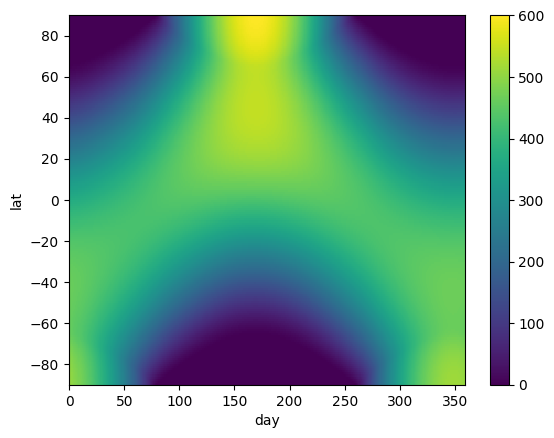

In [ ]:
#from https://epic.awi.de/id/eprint/55839/1/Master_Thesis_Endurance_Igbniosa.pdf

""""
     PI             LIG
Jan  02Jan - 30Jan  26Dec - 27Jan
Feb  31Jan - 01Mar  28Jan - 28Feb
Mar  02Mar - 31Mar  01Mar - 31Mar
Apr  01Apr - 01May  01Apr - 30Apr
May  02May - 01Jun  01May - 29May
Jun  02Jun - 02Jul  30May - 26Jun
Jul  03Jul - 02Aug  27Jun - 24Jul
Aug  03Aug - 02Sep  25Jul - 22Aug
Sep  03Sep - 03Oct  23Aug - 20Sep
Oct  04Oct - 02Nov  21Sep - 21Oct
Nov  03Nov - 02Dec  22Oct - 22Nov
Dec  03Dec - 01Jan  23Nov - 25Dec
"""



In [ ]:

def paleo_cal_adjust(cal, data, standard_month_length=30):
     
     #create a blank variable of the same type as 'data', but with 360 columns
     #this is to store the interpolated data
     interpolated_data = np.zeros((data.shape[0], 360))

     for i in range(len(cal)):
     
          if cal[0] > cal[1]:
               if i == 0:
                    month_slice = xr.concat([data[:,cal[i]-1:data.shape[1]-1], data[:,0:cal[1]-1]], dim='day')
                    month_slice['day'] = np.arange(1,month_slice.shape[1]+1)
                    
               elif i == len(cal)-1:
                    month_slice = data[:,cal[i]-1:cal[0]-1]
               else:
                    month_slice = data[:,cal[i]-1:cal[i+1]-1]     
          else:          
               if i == len(cal)-1:
                    #get the last slice and first slice and combine them
                    #month_slice = data[:,cal[i]-1:data.shape[1]-1] + data[:,0:cal[0]]
                    month_slice = xr.concat([data[:,cal[i]-1:data.shape[1]-1], data[:,0:cal[0]-1]], dim='day')
                    month_slice['day'] = np.arange(1,month_slice.shape[1]+1)
                    
               else:
                    #need to add code to handle January starting in Dec (i.e. cal[0] is greater than cal[1])
                    month_slice = data[:,cal[i]-1:cal[i+1]-1]
          print(i)
          days = month_slice.day
          insolation = month_slice.values

          x_old= np.arange(len(days) + 1)
          cs = CubicSpline(days,insolation,axis=1)
          x_new = np.linspace(days[0], days[-1], 30)
          y_new = cs(x_new)

          interpolated_data[:,i*standard_month_length:(i+1)*standard_month_length] = np.maximum(y_new,0) #remove negative values from interpolation


     interpolated_data = xr.DataArray(interpolated_data, coords=[data.lat, np.arange(360)], dims=['lat', 'day'])
     return interpolated_data

0
1
2
3
4
5
6
7
8
9
10
<xarray.DataArray 'piControl' (lat: 180, day: 30)> Size: 22kB
array([[518.558  , 522.26154, 525.7998 , ..., 557.26776, 556.1736 ,
        554.89746],
       [518.4    , 522.1024 , 525.63965, ..., 557.098  , 556.00415,
        554.72845],
       [518.08417, 521.7843 , 525.3194 , ..., 556.75854, 555.6654 ,
        554.39044],
       ...,
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ],
       [  0.     ,   0.     ,   0.     , ...,   0.     ,   0.     ,
          0.     ]], dtype=float32)
Coordinates:
  * lat      (lat) float32 720B -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * day      (day) int32 120B 1 2 3 4 5 6 7 8 9 ... 22 23 24 25 26 27 28 29 30
11
<xarray.DataArray 'lig127k' (lat: 180, day: 33)> Size: 24kB
array([[503.84875, 502.29272, 500.61905, ..., 400.64032, 395.52145,
        390.29422],
       [503.69525, 502.13974, 500.46

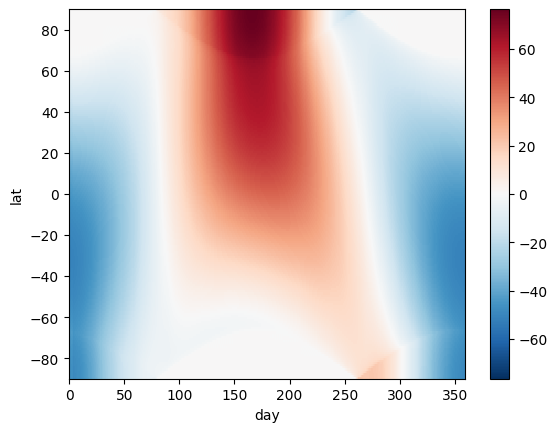

In [95]:
pi_proper = paleo_cal_adjust(pi_cal, pi1)
lig_proper = paleo_cal_adjust(lig_cal, lig1)

anomalies = lig_proper - pi_proper

anomalies.plot()

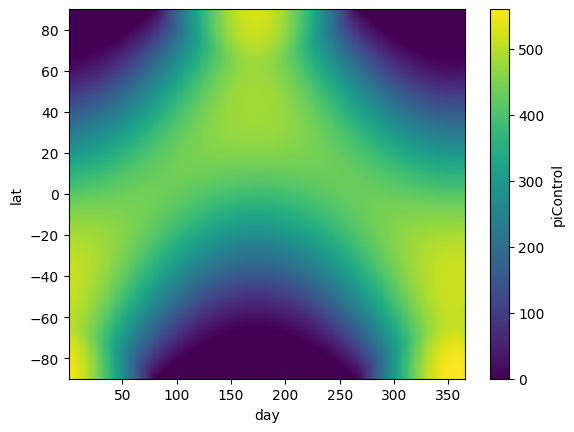

In [53]:
data.plot()

In [ ]:
pi_date_string = ["02Jan", "31Jan", "02Mar", "01Apr", "02May", "02Jun", "03Jul", "03Aug", "03Sep", "04Oct", "03Nov", "03Dec"]
lig_date_string = ["26Dec", "28Jan", "01Mar", "01Apr", "01May", "30May", "27Jun", "25Jul", "23Aug", "21Sep", "22Oct", "23Nov"]

pi_date_numbers = [datetime.strptime(date, "%d%b").timetuple().tm_yday for date in pi_date_string]
lig_date_numbers = [datetime.strptime(date, "%d%b").timetuple().tm_yday for date in lig_date_string]

print(pi_date_numbers)
print(lig_date_numbers)

#Plan
#Strip out the relevant 'month' section from the unadjusted data
#Interpolate it to a much higher frequency than daily(get the code from my dissertation for the ITCZ)
#Get the values for every 1/30th of this, equivalent to a standardised month
#Stitch it all together. 
#
#Use the function that generates the length of the months to check the dates above
#Assume that March always ends on the 31st
#Then count forwards from the 4th data point to get the days from the python code. 

[2, 31, 61, 91, 122, 153, 184, 215, 246, 277, 307, 337]
[360, 28, 60, 91, 121, 150, 178, 206, 235, 264, 295, 327]


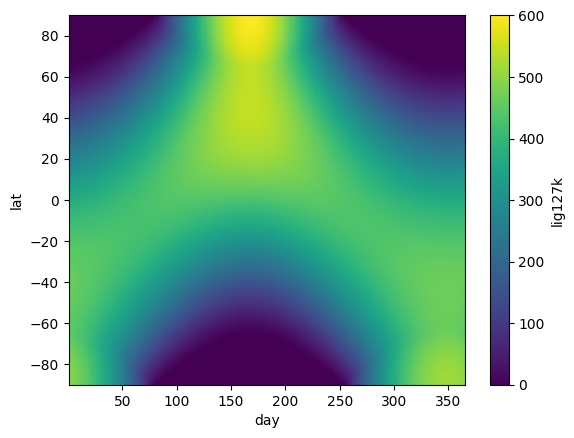

In [ ]:
#pi1.plot()
vernal_equinox = 80
#shift the first 80 days to the end of the year in lig1
lig1_temp = np.roll(lig1, -vernal_equinox, axis=1)
lig1.plot()


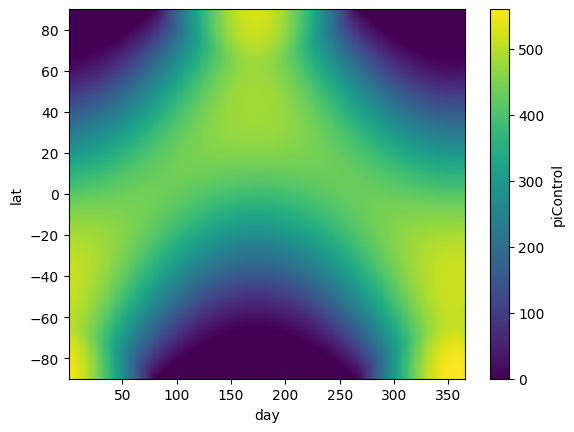

In [141]:
pi1.plot()
#lig1 and pi1 have Jan at start. lig, pi have vernal equinox at start


In [137]:
lig1_adjusted = compress_paleo_to_modern(lig1.T, lig_cal, pi_cal)
lig1_adjusted = lig1_adjusted.T

#offset lig1_adjusted so that 80th day is the same as lig1
offset = lig1[:, vernal_equinox] - lig1_adjusted[:, vernal_equinox]
offset= offset.T

offset = np.array(offset)

# Expand to a column vector: shape becomes (180, 1)
offset_expanded = offset[:, np.newaxis]

# Duplicate the column 365 times to create a (180, 365) array.
offset_repeated = np.tile(offset_expanded, (1, 365))
lig1_adjusted_offset = lig1_adjusted + offset_repeated
#offset = offset[:, np.newaxis]
#lig1_adjusted_offset = lig1_adjusted + offset


In [138]:
pi1_adjusted = compress_paleo_to_modern(pi1.T, pi_cal, pi_cal)
pi1_adjusted = pi1_adjusted.T

#offset lig1_adjusted so that 80th day is the same as lig1
offset = pi1[:, vernal_equinox] - pi1_adjusted[:, vernal_equinox]
offset= offset.T

offset = np.array(offset)

# Expand to a column vector: shape becomes (180, 1)
offset_expanded = offset[:, np.newaxis]

# Duplicate the column 365 times to create a (180, 365) array.
offset_repeated = np.tile(offset_expanded, (1, 365))
pi1_adjusted_offset = pi1_adjusted + offset_repeated
#offset = offset[:, np.newaxis]
#lig1_adjusted_offset = lig1_adjusted + offset


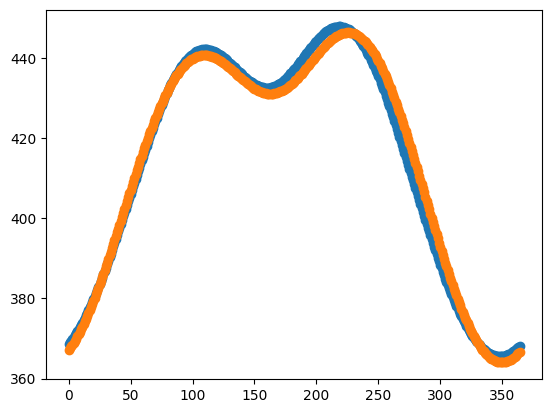

In [143]:
#scatter plot of pi1_adjusted_offset[90,:]

x = np.arange(365)
y = lig1_adjusted_offset[90, :]
plt.scatter(x, y)

#add pi1[90,:] to the plot

y = lig1[90, :]
plt.scatter(x, y)

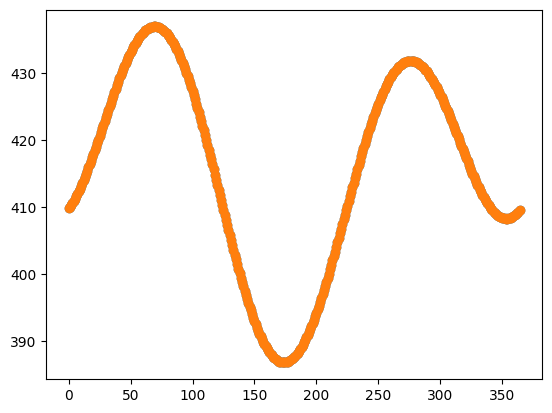

In [166]:
#scatter plot of pi1_adjusted_offset[90,:]

x = np.arange(365)
y = pi1_adjusted_offset[90, :]
plt.scatter(x, y)

#add pi1[90,:] to the plot

y = pi1[90, :]
plt.scatter(x, y)




TypeError: Length of x (365) must match number of columns in z (360)

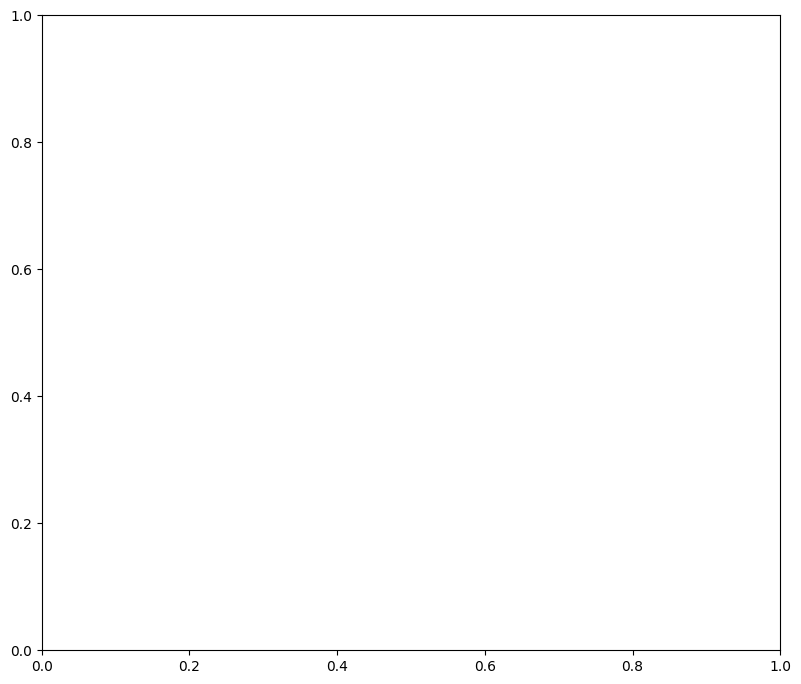

In [93]:
# lig
#define colours
c80 = '#B15928'
c70 = '#E69F00'
c60 = '#FFD700'

fig=plt.figure(figsize=(20,18))

cmap=plt.get_cmap('seismic')
bounds =[-200,-80,-70,-60,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50,60,70,80,200]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

ax1=plt.subplot2grid((26, 25), (0, 0),rowspan=12, colspan=12)
fig1=ax1.contourf(day,lat,lig_proper - pi_proper,levels=bounds,cmap=cmap,norm=norm)
ax1.set_xticks(monlocation)
ax1.set_xticklabels(monname, fontsize=12)
ax1.set_title('(a) Latitude-daily insolation anomaly between 127ka and PI',loc='left',fontsize=15)
#Put vertical lines to show the months for Pi and LIG. Removed for now
#for i in range(12):
#    ax1.axvline(x=piline[i],color='k',linestyle="dashed",linewidth=1.5)
#    ax1.axvline(x=ligline[i],color='k',linestyle='dotted',linewidth=1.5)
ax1.set_ylabel('Latitude (%sN)'%chr(176),fontsize=15 )
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=0.3, pack_start=True)
fig.add_axes(cax)
cb=fig.colorbar(fig1, cax=cax, orientation="horizontal")
cb.ax.tick_params(labelsize=12)
cblabel='Insolation difference (W m$^{-2}$)'
cb.set_label(cblabel,fontsize=12)

# Set colorbar ticks to include 0 and every two ticks from there
ticks = [-80, -60, -40, -20, -10, 0, 10, 20, 40, 60, 80]
cb.set_ticks(ticks)

ax2=plt.subplot2grid((26, 25), (0, 12), rowspan=11,colspan=2)
fig2=ax2.plot(np.average(lig-pi,axis=1),lat,'black')
ax2.axvline(x=0,color='gray',linestyle="--",linewidth=2)
ax2.set_xlabel('W m$^{-2}$', fontsize=12)
ax2.set_title('(b) lat. ave',fontsize=15)
ax2.tick_params(axis='x', labelsize=12)
ax2.set_ylim([-90,90])
#ax2.axhline(y=60,color=c60,ls='dashed')
#ax2.axhline(y=70,color=c70,ls='dashed')
#ax2.axhline(y=80,color=c80,ls='dashed')
ax2.yaxis.tick_right()

#ax2.set_ylabel('latitude (%sN)'%chr(176),fontsize=12 )

ax3=plt.subplot2grid((26, 25), (14, 0), rowspan=12,colspan=12)

ax3.plot(day,np.average(lig[149:151],axis=0),color='goldenrod',ls='solid',label='127ka 60%sN'%(chr(176)))
#ax3.plot(day,np.average(lig[159:161],axis=0),color=c70,ls='solid',label='70%sN'%(chr(176)))
ax3.plot(day,np.average(lig[169:171],axis=0),color='darkorange',ls='solid',label='127ka 80%sN'%(chr(176)))

ax3.plot(day,np.average(pi[149:151],axis=0),color='limegreen',ls='solid',label='PI 60%sN'%(chr(176)))
#ax3.plot(day,np.average(lig[159:161],axis=0),color=c70,ls='solid',label='70%sN'%(chr(176)))
ax3.plot(day,np.average(pi[169:171],axis=0),color='darkgreen',ls='solid',label='PI 80%sN'%(chr(176)))

ax3.set_xticks(monlocation)
ax3.set_xlim([0,365])
ax3.set_xticklabels(monname, fontsize=12)
ax3.set_title('(c) Insolation',loc='left',fontsize=15)
ax3.set_ylim([0,600])
ax3.set_ylabel('Insolation (W m$^{-2}$)', fontsize=12 )


ax3_right = ax3.twinx()


diff=np.array(lig-pi)

#ax3_right.axhline(y=0,color='gray',linestyle="-",linewidth=1)
ax3_right.plot(day,np.average(diff[149:151],axis=0),'gray',ls='dashed',label='Anomaly 60%sN'%(chr(176)))
#ax3_right.plot(day,np.average(diff[159:161],axis=0),c70,ls='dashed',label='70%sN'%(chr(176)))
ax3_right.plot(day,np.average(diff[169:171],axis=0),'black',ls='dashed',label='Anomaly 80%sN'%(chr(176)))
ax3_right.set_ylabel('Insolation Anomaly (W m$^{-2}$)', fontsize=12 )
ax3_right.set_ylim([-200,200])
#onlyshow ticks up to +/-100 on the y axis
ax3_right.set_yticks(np.arange(-100,101,50))

"""
# Custom legend for line styles
solid_line = Line2D([0], [0], color='black', lw=2, linestyle='-')
dashed_line = Line2D([0], [0], color='black', lw=2, linestyle='--')

# Combine existing legend handles with custom handles
handles, labels = ax3.get_legend_handles_labels()
handles += [solid_line, dashed_line]
labels += ['127ka', 'Anomaly']
"""

#combine ax3 and ax3_right legends
handles, labels = ax3.get_legend_handles_labels()
handles_right, labels_right = ax3_right.get_legend_handles_labels()
handles += handles_right
labels += labels_right

# Add combined legend to the plot
ax3.legend(handles, labels, loc='upper right')



#plt.savefig('lig_insolation.png')
#plt.savefig('lig_insolation.pdf')  


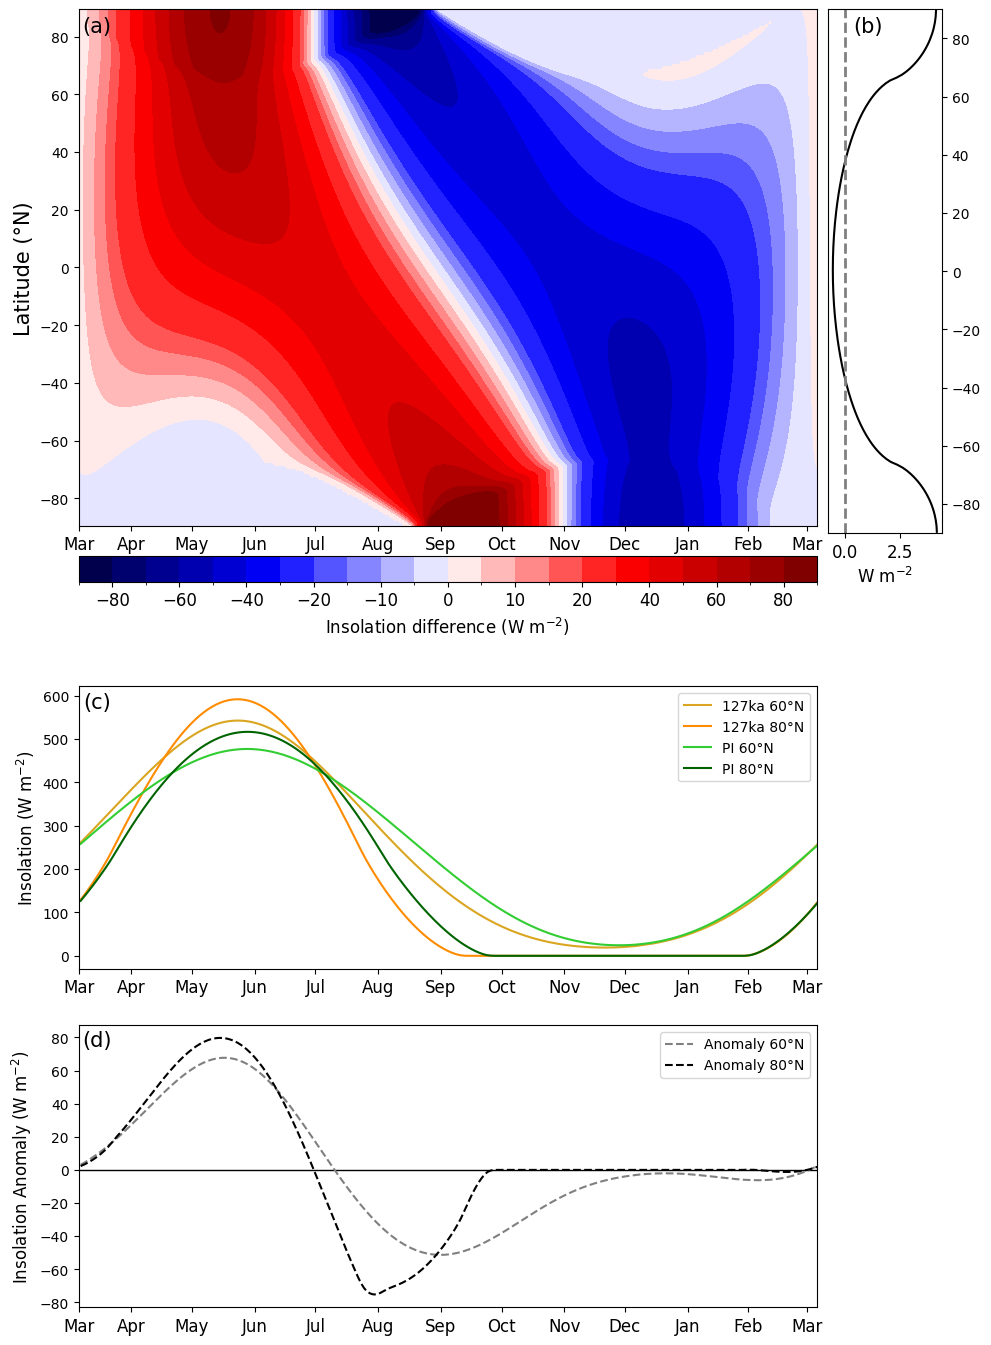

In [69]:
fig=plt.figure(figsize=(20,20))

cmap=plt.get_cmap('seismic')
bounds =[-200,-80,-70,-60,-50,-40,-30,-20,-15,-10,-5,0,5,10,15,20,30,40,50,60,70,80,200]
norm = colors.BoundaryNorm(boundaries=bounds, ncolors=256)

ax1=plt.subplot2grid((32, 25), (0, 0),rowspan=12, colspan=12)
fig1=ax1.contourf(day,lat,lig-pi,levels=bounds,cmap=cmap,norm=norm)
ax1.set_xticks(monlocation)
ax1.set_xticklabels(monname, fontsize=12)
ax1.set_title('(a)',fontsize=15, y=0.94, x=0.025)
#Put vertical lines to show the months for Pi and LIG. Removed for now
#for i in range(12):
#    ax1.axvline(x=piline[i],color='k',linestyle="dashed",linewidth=1.5)
#    ax1.axvline(x=ligline[i],color='k',linestyle='dotted',linewidth=1.5)
ax1.set_ylabel('Latitude (%sN)'%chr(176),fontsize=15 )
divider = make_axes_locatable(ax1)
cax = divider.new_vertical(size="5%", pad=0.3, pack_start=True)
fig.add_axes(cax)
cb=fig.colorbar(fig1, cax=cax, orientation="horizontal")
cb.ax.tick_params(labelsize=12)
cblabel='Insolation difference (W m$^{-2}$)'
cb.set_label(cblabel,fontsize=12)

# Set colorbar ticks to include 0 and every two ticks from there
ticks = [-80, -60, -40, -20, -10, 0, 10, 20, 40, 60, 80]
cb.set_ticks(ticks)

ax2=plt.subplot2grid((32, 25), (0, 12), rowspan=11,colspan=2)
fig2=ax2.plot(np.average(lig-pi,axis=1),lat,'black')
ax2.axvline(x=0,color='gray',linestyle="--",linewidth=2)
ax2.set_xlabel('W m$^{-2}$', fontsize=12)
ax2.set_title('(b)',fontsize=15, y=0.94, x=0.35)
ax2.tick_params(axis='x', labelsize=12)
ax2.set_ylim([-90,90])
#ax2.axhline(y=60,color=c60,ls='dashed')
#ax2.axhline(y=70,color=c70,ls='dashed')
#ax2.axhline(y=80,color=c80,ls='dashed')
ax2.yaxis.tick_right()

#ax2.set_ylabel('latitude (%sN)'%chr(176),fontsize=12 )

ax3=plt.subplot2grid((32, 25), (14, 0), rowspan=6,colspan=12)

ax3.plot(day,np.average(lig[149:151],axis=0),color='goldenrod',ls='solid',label='127ka 60%sN'%(chr(176)))
#ax3.plot(day,np.average(lig[159:161],axis=0),color=c70,ls='solid',label='70%sN'%(chr(176)))
ax3.plot(day,np.average(lig[169:171],axis=0),color='darkorange',ls='solid',label='127ka 80%sN'%(chr(176)))

ax3.plot(day,np.average(pi[149:151],axis=0),color='limegreen',ls='solid',label='PI 60%sN'%(chr(176)))
#ax3.plot(day,np.average(lig[159:161],axis=0),color=c70,ls='solid',label='70%sN'%(chr(176)))
ax3.plot(day,np.average(pi[169:171],axis=0),color='darkgreen',ls='solid',label='PI 80%sN'%(chr(176)))

ax3.set_xticks(monlocation)
ax3.set_xlim([0,365])
ax3.set_xticklabels(monname, fontsize=12)
ax3.set_title('(c)',fontsize=15, y=0.895, x=0.025)
ax3.set_ylabel('Insolation (W m$^{-2}$)', fontsize=12 )

#add legend upper right
ax3.legend(loc='upper right')

ax4=plt.subplot2grid((32, 25), (21, 0), rowspan=6,colspan=12)

diff=np.array(lig-pi)

ax4.axhline(y=0,color='black',linestyle="-",linewidth=1)
ax4.plot(day,np.average(diff[149:151],axis=0),'gray',ls='dashed',label='Anomaly 60%sN'%(chr(176)))
#ax3_right.plot(day,np.average(diff[159:161],axis=0),c70,ls='dashed',label='70%sN'%(chr(176)))
ax4.plot(day,np.average(diff[169:171],axis=0),'black',ls='dashed',label='Anomaly 80%sN'%(chr(176)))
ax4.set_ylabel('Insolation Anomaly (W m$^{-2}$)', fontsize=12 )


ax4.set_xticks(monlocation)
ax4.set_xlim([0,365])
ax4.set_xticklabels(monname, fontsize=12)
ax4.set_title('(d)',fontsize=15, y=0.895, x=0.025)
ax4.set_ylabel('Insolation Anomaly (W m$^{-2}$)', fontsize=12 )
#add 0 axis


ax4.legend(loc='upper right')


plt.savefig('lig_insolation.png')
plt.savefig('lig_insolation.pdf') 